### Beginning
The first thing is import the needed module. Like below:

In [11]:
import csv
import cv2
import random
import sklearn
import numpy as np
from keras.models import Sequential
from keras.layers import Flatten,Dense,Lambda,Dropout
from keras.layers.convolutional import Convolution2D, Cropping2D,MaxPooling2D
from sklearn.model_selection import train_test_split

### 1-Solve the data of image and contrall
We need get the image of traffic and the contrall of traffic. Here I directly use the given traning [data](https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip). I am a little lazy for collecting the train data (Because I find I hardly drive in simulator, forgive me!).

In [3]:
samples = []
with open("./data/driving_log.csv") as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

The data in csv file is about the path of image and the contrall infomation. The list of data is 'center,left,right,steering,throttle,brake,speed'. Here we can see it like below:

In [4]:
print(samples[1])

['IMG/center_2016_12_01_13_30_48_404.jpg', ' IMG/left_2016_12_01_13_30_48_404.jpg', ' IMG/right_2016_12_01_13_30_48_404.jpg', ' 0', ' 0', ' 0', ' 21.87963']


The first data is the path of center camera image data, the second data is the path of left camera image data, the third data is the path of right camera image data. And next three data is the index of steer, throttle and brake. The last is speed data.

We can see the three image data is like below:

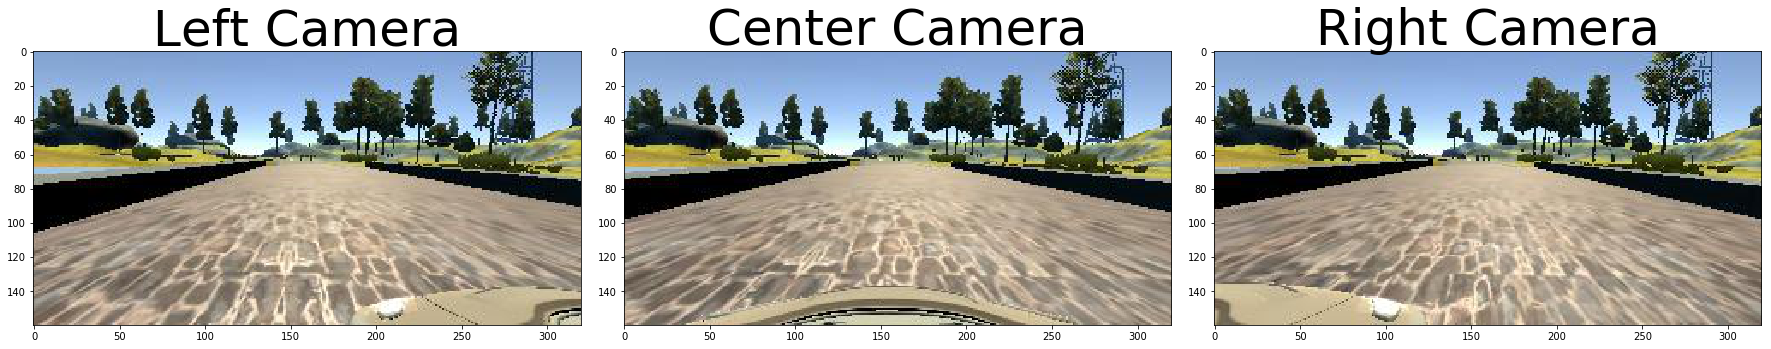

In [5]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
center_img = mpimg.imread('./data/IMG/' + samples[1][0].split('/')[-1])
left_img = mpimg.imread('./data/IMG/' + samples[1][1].split('/')[-1])
right_img = mpimg.imread('./data/IMG/' + samples[1][2].split('/')[-1])
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(left_img)
ax1.set_title('Left Camera', fontsize=50)
ax2.imshow(center_img)
ax2.set_title('Center Camera', fontsize=50)
ax3.imshow(right_img)
ax3.set_title('Right Camera', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=2, bottom=0.)

### 2-Implement of the generator

But I want to only take care about the center camera data. So I load the center camera data through the Generators.

In [12]:
def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        random.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                name = './data/IMG/'+batch_sample[0].split('/')[-1]
                center_image = cv2.imread(name)
                center_angle = float(batch_sample[3])
                images.append(center_image)
                angles.append(center_angle)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

I split the data into training and validate sample.

### 3-Split the sample into train data and validation data

In [13]:
train_samples, validation_samples = train_test_split(samples, test_size=0.2)
# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

### 4-Implement of model

Now I make my model for this case. The Keras model I build, is very close with NVIDIA model only for some modifications. 

First I start a Sequential model and directly add a lambda layer to normalize the data for input shape of image size that is 160x320x3.

Then I use a cropping layer to cut 75 pixels from top that is basically sky, tree, etc and to cut 25 pixels from bottom that is filled with car itself, and cut 20 pixels from left and right side each that is no use for train. The advantage is that increases training speed by decreasing the data size and clear the data we don't care about. 

After these layers, the model has 3 convolutional layers with filter size of 3X3 that increases output depth to 16, 32 and 64 in each layer. All of these convolutional layers have Relu activation and also followed by maxpooling with size of 2x2. The maxpooling layers help keep the system away from overfitting. Then I have a flatten layer followed by 4 fully connected layers that decreases the depth from 400 to 100, from 100 to 20 and from 20 to 1 that is final output. 

Final output is the angel that we need for driving the car. And I use Adam optimizer to minimize Mean Squared Error as our criteria for minimizing the error in output.

Now we can fit the data by generators.

In [21]:
ch, row, col = 3, 160, 320  # Trimmed image format

model = Sequential()
# Preprocess incoming data, centered around zero with small standard deviation 
model.add(Lambda(lambda x: x/255.0 - 0.5,
        input_shape=(row, col, ch)))
model.add(Cropping2D(cropping=((70, 20),(10, 10))))

# model is from NVIDIA
model.add(Convolution2D(16, 3,3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(32, 3, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(64, 3, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(400, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
model.fit_generator(train_generator, samples_per_epoch=len(train_samples), validation_data=validation_generator, nb_val_samples=len(validation_samples), nb_epoch=5)

Epoch 1/5
6428/6428 [==============================] - 8s - loss: 0.0121 - val_loss: 0.0100
Epoch 2/5
6428/6428 [==============================] - 7s - loss: 0.0090 - val_loss: 0.0096
Epoch 3/5
6428/6428 [==============================] - 7s - loss: 0.0087 - val_loss: 0.0108
Epoch 4/5
6428/6428 [==============================] - 7s - loss: 0.0081 - val_loss: 0.0087
Epoch 5/5
6428/6428 [==============================] - 7s - loss: 0.0079 - val_loss: 0.0090


We should save the model for using in other place, so we solve the model by [keras function](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model). Like below:

In [9]:
model.save('model.h5')

### Problem-1

I apply the model to auto-drive, but get a bad result. It drives outside of road. Like below:
<img src="./images/error-1.png"/>

### Improvement-1

So we should collect more data for training. There are three camera, so we can apply the three camera data to train model. For different camera data, we should append the steer data with a correction. We treat the center camera as origin point and add correction for left camera and decrese correction for right camera.

And for getting more data, we can also collect the data of Counter-Clockwise driving.

So now we got a new generator function:

In [20]:
def generator_multi_camera(samples, batch_size=32):
    num_samples = len(samples)
    correction = 0.2
    while 1: # Loop forever so the generator never terminates
        random.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                center_angle = float(batch_sample[3])
                flipped_center_angle = (center_angle) * -1.0
                for i in range(3):
                    name = './data/IMG/'+batch_sample[i].split('/')[-1]
                    image = cv2.imread(name)
                    images.append(image)
                    flipped_image = cv2.flip(image, 1)
                    images.append(flipped_image)
                    if i == 0:
                        angle = center_angle
                        flipped_angle = flipped_center_angle
                    elif i == 1:
                        angle = center_angle + correction
                        flipped_angle = flipped_center_angle + correction
                    else:
                        angle = center_angle - correction
                        flipped_angle = flipped_center_angle - correction
                    angles.append(angle)
                    angles.append(flipped_angle)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

Because I use three camera data for training, I need change the size of sample by multi 6 times. I change the model like below:
```
model.fit_generator(train_generator, samples_per_epoch=len(train_samples)*6, validation_data=validation_generator, nb_val_samples=len(validation_samples)*6, nb_epoch=8)
```
The new model is trained below:

In [22]:
train_samples, validation_samples = train_test_split(samples, test_size=0.2)
# compile and train the model using the generator function
train_generator = generator_multi_camera(train_samples, batch_size=32)
validation_generator = generator_multi_camera(validation_samples, batch_size=32)
ch, row, col = 3, 160, 320  # Trimmed image format

model = Sequential()
# Preprocess incoming data, centered around zero with small standard deviation 
model.add(Lambda(lambda x: x/255.0 - 0.5,
        input_shape=(row, col, ch)))
model.add(Cropping2D(cropping=((70, 20),(10, 10))))

# model is from NVIDIA
model.add(Convolution2D(16, 3,3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(32, 3, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(64, 3, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(400, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
model.fit_generator(train_generator, samples_per_epoch=len(train_samples)*6, validation_data=validation_generator, nb_val_samples=len(validation_samples)*6, nb_epoch=5)

Epoch 1/5
38568/38568 [==============================] - 44s - loss: 0.0222 - val_loss: 0.0118
Epoch 2/5
38568/38568 [==============================] - 41s - loss: 0.0104 - val_loss: 0.0094
Epoch 3/5
38568/38568 [==============================] - 42s - loss: 0.0091 - val_loss: 0.0098
Epoch 4/5
38568/38568 [==============================] - 43s - loss: 0.0083 - val_loss: 0.0093
Epoch 5/5
38568/38568 [==============================] - 42s - loss: 0.0075 - val_loss: 0.0082


### Problem 2 And Improvement

The sample data I collect is 6 times of the first time. And the loss of train is also pretty. Now I test in autodrive mode. But I find the same behavior occur in same place. Like below:
<img src="./images/error-2.png"/>
Why? I check this place point and find there no drive line in right side. So I think maybe the reason is with the data itself. I check the data and find the data privided is both driving in center place and no recovery driving from the sides. Maybe I should collect the data myself. So I collect the data and order the guidelines for data collection:
* two or three laps of center lane driving
* one lap of recovery driving from the sides
* one lap focusing on driving smoothly around curves

At last, I complete the project and make the video. Ha ha ha....